### 导入相关的包

In [1]:
"""
original code from rwightman:
https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
"""

from functools import partial
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from tqdm import tqdm
from PIL import Image

import os
import sys
import json
import pickle
import random
import math
import argparse

import matplotlib.pyplot as plt


### 定义模型板块、模型类、模型函数

In [2]:

'''
实现随机深度（Stochastic Depth）

在ResNet中，每一层的输出都与其输入相加，这样会导致网络的深度不断增加，导致网络的复杂度不断增加。
而随机深度（Stochastic Depth）是一种正则化方法，通过随机丢弃网络的某些层来减少网络的深度，从而提升网络的性能。
随机深度的实现方法是：在每一层的输出前面加一个丢弃层（DropPath），丢弃层的丢弃率是可学习的，
这样就可以在训练过程中，根据丢弃率来随机丢弃网络的某些层，从而达到随机深度的效果。

x:输入张量
drop_prob:丢弃率，是一个浮点数，即每个路径（或神经元连接）被丢弃的概率。
training:是否在训练模式下运行。如果不是，则不进行丢弃，即丢弃率为零。
'''
def drop_path(x, drop_prob: float = 0., training: bool = False):
    """
    Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).
    This is the same as the DropConnect impl I created for EfficientNet, etc networks, however,
    the original name is misleading as 'Drop Connect' is a different form of dropout in a separate paper...
    See discussion: https://github.com/tensorflow/tpu/issues/494#issuecomment-532968956 ... I've opted for
    changing the layer and argument names to 'drop path' rather than mix DropConnect as a layer name and use
    'survival rate' as the argument.
    """
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob  # 计算保留概率

    # 生成随机张量
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # 使用diff-dim张量，而不仅仅是2D卷积网络。
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize（二值化）
    output = x.div(keep_prob) * random_tensor
    return output


class DropPath(nn.Module):
    """
    Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)

'''
将输入的2D图像转化为一个序列的嵌入向量
'''
class PatchEmbed(nn.Module):
    """
    2D Image to Patch Embedding
    """
    # in_c:输入通道数，3，通常为RGB。
    # 我在想这里的img_size和patch_size直接以元组的形式传入是否会更方便。
    def __init__(self, img_size=224, patch_size=16, in_c=3, embed_dim=768, norm_layer=None):
        super().__init__()
        img_size = (img_size, img_size) # 将图片大小和patch大小都转换为元组，方便后面的计算
        patch_size = (patch_size, patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_size = (img_size[0] // patch_size[0], img_size[1] // patch_size[1]) # 计算patch网格大小
        self.num_patches = self.grid_size[0] * self.grid_size[1]  # patchs的数量

        self.proj = nn.Conv2d(in_c, embed_dim, kernel_size=patch_size, stride=patch_size)
        '''
        为何这里的卷积不需要padding呢？
        因为stride=kernel_size，每个像素块在一次卷积中都只参与一次。
        而padding适用于中间部分像素块由重复参与卷积的情况。
        '''
        self.norm = norm_layer(embed_dim) if norm_layer else nn.Identity()

    def forward(self, x):
        B, C, H, W = x.shape
        # 要求输入的图片大小必须和初始化时设置的img_size一致
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        # proj(x)：用二维卷积进行投影，其实就是切割缩小啦。
        # flatten: [B, C, H, W] -> [B, C, HW]
        # transpose: [B, C, HW] -> [B, HW, C]
        x = self.proj(x).flatten(2).transpose(1, 2)
        x = self.norm(x)
        return x

'''
实现多头注意力机制

dim:输入token的dim
num_heads:多头注意力机制的头数
qkv_bias:在查询Q、键K、值V矩阵的线性变换中是否添加偏置
qk_scale:用来缩放查询Q、键K矩阵的尺度。默认是None，表示不缩放。
attn_drop_ratio:注意力权重矩阵的dropout的概率
proj_drop_ratio:投影矩阵的dropout的概率
'''
class Attention(nn.Module):
    def __init__(self,
                 dim,   # 输入token的dim
                 num_heads=8,
                 qkv_bias=False,
                 qk_scale=None,
                 attn_drop_ratio=0.,
                 proj_drop_ratio=0.):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads  # 每个头的维度
        self.scale = qk_scale or head_dim ** -0.5  # 缩放因子，论文中默认为head_dim的倒数。
        # 如果参数中没有指定qk_scale，则使用默认的缩放因子。

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias) # 生成q、k、v三个矩阵的组合
        # 生成q、k、v三个矩阵所用到的权重矩阵是Linear层自己提供的，
        # 这权重矩阵的维度是[dim, dim * 3]，在初始化不用满足什么条件（只要不为零就行），因为反正他是个可学习的参数。

        self.attn_drop = nn.Dropout(attn_drop_ratio)  # 为什么不用自己定义的DropPath呢？
        self.proj = nn.Linear(dim, dim) # 投影的线性层，将注意力输出的维度还原到输入的维度
        self.proj_drop = nn.Dropout(proj_drop_ratio) # 应用在投影输出上的dropout

    def forward(self, x):
        # [batch_size, num_patches + 1, total_embed_dim]
        B, N, C = x.shape

        # qkv(): -> [batch_size, num_patches + 1, 3 * total_embed_dim]
        # reshape: -> [batch_size, num_patches + 1, 3, num_heads, embed_dim_per_head]
        # permute: -> [3, batch_size, num_heads, num_patches + 1, embed_dim_per_head]
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        # [batch_size, num_heads, num_patches + 1, embed_dim_per_head]
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        # transpose: -> [batch_size, num_heads, embed_dim_per_head, num_patches + 1]
        # @: multiply -> [batch_size, num_heads, num_patches + 1, num_patches + 1]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        # @: multiply -> [batch_size, num_heads, num_patches + 1, embed_dim_per_head]
        # transpose: -> [batch_size, num_patches + 1, num_heads, embed_dim_per_head]
        # reshape: -> [batch_size, num_patches + 1, total_embed_dim]
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

"""
MLP as used in Vision Transformer, MLP-Mixer and related networks

in_features:输入特征的维度
hidden_features:隐藏层的维度，默认等于输入特征的维度
out_features:输出特征的维度，默认等于输入特征的维度
act_layer:激活层，默认是GELU
drop:dropout的概率，默认是0.
"""
class Mlp(nn.Module):
    
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        # 如果数据小的话，下面这两层可以不要。
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)

        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

'''
transformer encoder 中的基本快

dim:输入token的dim
num_heads:多头注意力机制的头数
mlp_ratio:MLP的隐藏层维度与输入token的维度的比值
qkv_bias:在查询Q、键K、值V矩阵的线性变换中是否添加偏置
qk_scale:用来缩放查询Q、键K矩阵的尺度。默认是None，表示不缩放。
drop_ratio:MLP和注意力机制后的dropout的概率
attn_drop_ratio:注意力权重矩阵的dropout的概率
drop_path_ratio:随机深度丢失的概率，用于正则化。
act_layer:激活层
norm_layer:归一化层
'''
class Block(nn.Module):
    def __init__(self,
                 dim,
                 num_heads,
                 mlp_ratio=4.,
                 qkv_bias=False,
                 qk_scale=None,
                 drop_ratio=0.,
                 attn_drop_ratio=0.,
                 drop_path_ratio=0.,
                 act_layer=nn.GELU,
                 norm_layer=nn.LayerNorm):
        super(Block, self).__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
                              attn_drop_ratio=attn_drop_ratio, proj_drop_ratio=drop_ratio)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        # 如果drop_path_ratio=0，则不使用随机深度。如果drop_path_ratio>0，则使用随机深度。 
        self.drop_path = DropPath(drop_path_ratio) if drop_path_ratio > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop_ratio)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

"""
Args:
    img_size (int, tuple): input image size
    patch_size (int, tuple): patch size
    in_c (int): number of input channels
    num_classes (int): number of classes for classification head，分类头的输出类别数
    embed_dim (int): embedding dimension
    depth (int): depth of transformer ，即block的数量
    num_heads (int): number of attention heads，多头注意力机制中头的数量
    mlp_ratio (int): ratio of mlp hidden dim to embedding dim
    qkv_bias (bool): enable bias for qkv if True
    qk_scale (float): override default qk scale of head_dim ** -0.5 if set
    representation_size (Optional[int]): enable and set representation layer (pre-logits) to this value if set
    如果有设置，表示层的维度，用于logits层
    distilled (bool): model includes a distillation token and head as in DeiT models
    是否为蒸馏模型，即是否包含蒸馏token和头（如DeiT模型）
    drop_ratio (float): dropout rate
    attn_drop_ratio (float): attention dropout rate
    drop_path_ratio (float): stochastic depth rate
    embed_layer (nn.Module): patch embedding layer
    norm_layer: (nn.Module): normalization layer
"""
class VisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_c=3, num_classes=1000,
                 embed_dim=768, depth=12, num_heads=12, mlp_ratio=4.0, qkv_bias=True,
                 qk_scale=None, representation_size=None, distilled=False, drop_ratio=0.,
                 attn_drop_ratio=0., drop_path_ratio=0., embed_layer=PatchEmbed, norm_layer=None,
                 act_layer=None):
        
        super(VisionTransformer, self).__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        self.num_tokens = 2 if distilled else 1
        norm_layer = norm_layer or partial(nn.LayerNorm, eps=1e-6)
        act_layer = act_layer or nn.GELU

        self.patch_embed = embed_layer(img_size=img_size, patch_size=patch_size, in_c=in_c, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim)) # 分类token
        self.dist_token = nn.Parameter(torch.zeros(1, 1, embed_dim)) if distilled else None # 蒸馏token
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + self.num_tokens, embed_dim)) # 位置嵌入
        self.pos_drop = nn.Dropout(p=drop_ratio) # 位置drop层

        dpr = [x.item() for x in torch.linspace(0, drop_path_ratio, depth)]  # stochastic depth decay rule，随机深度衰减规律

        self.blocks = nn.Sequential(*[
            Block(dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                  drop_ratio=drop_ratio, attn_drop_ratio=attn_drop_ratio, drop_path_ratio=dpr[i],
                  norm_layer=norm_layer, act_layer=act_layer)
            for i in range(depth)
        ]) # 根据depth参数，用列表推导式构建多个block

        self.norm = norm_layer(embed_dim)

        # Representation layer
        if representation_size and not distilled:
            self.has_logits = True
            self.num_features = representation_size
            self.pre_logits = nn.Sequential(OrderedDict([
                ("fc", nn.Linear(embed_dim, representation_size)),
                ("act", nn.Tanh())
            ])) # 用于在分类头之前对特征进行进一步的处理
        else:
            self.has_logits = False
            self.pre_logits = nn.Identity()

        # Classifier head(s)
        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()
        self.head_dist = None
        if distilled:  # 如果distilled=True，则构建蒸馏头
            self.head_dist = nn.Linear(self.embed_dim, self.num_classes) if num_classes > 0 else nn.Identity()

        # Weight init
        nn.init.trunc_normal_(self.pos_embed, std=0.02) # 使用截断正态分布初始化位置嵌入
        if self.dist_token is not None:
            nn.init.trunc_normal_(self.dist_token, std=0.02) # 使用截断正态分布初始化蒸馏token

        nn.init.trunc_normal_(self.cls_token, std=0.02) # 使用截断正态分布初始化分类token
        self.apply(_init_vit_weights) # 剩下的其他层直接用自定义的权重初始化函数来进行初始化

    '''
    计算模型的前向传播，但是没有包含最终的分类头。
    '''
    def forward_features(self, x):
        # [B, C, H, W] -> [B, num_patches, embed_dim]
        x = self.patch_embed(x)  # [B, 196, 768]
        # [1, 1, 768] -> [B, 1, 768]
        cls_token = self.cls_token.expand(x.shape[0], -1, -1) # 将类token扩展到batch_size维度上
        if self.dist_token is None:  # 如果没有蒸馏token，则直接将cls_token和x拼接起来
            x = torch.cat((cls_token, x), dim=1)  # [B, 197, 768]
        else: # 如果有蒸馏token，则将cls_token、dist_token和x拼接起来
            x = torch.cat((cls_token, self.dist_token.expand(x.shape[0], -1, -1), x), dim=1)

        x = self.pos_drop(x + self.pos_embed) # 加入位置嵌入，然后dropout
        x = self.blocks(x)
        x = self.norm(x) 
        if self.dist_token is None: # 如果没有蒸馏token，则只取分类token的输出
            return self.pre_logits(x[:, 0])
        else: # 如果有蒸馏token，则取分类token和蒸馏token的输出
            return x[:, 0], x[:, 1]

    '''
    主要的forward函数，包含了前向传播和分类头。
    '''
    def forward(self, x):
        x = self.forward_features(x)
        if self.head_dist is not None: # 如果有蒸馏头，则将分类token和蒸馏token的输出作为输入
            x, x_dist = self.head(x[0]), self.head_dist(x[1])
            if self.training and not torch.jit.is_scripting(): # 如果是在训练模式而不是在脚本模式下，则返回两个分类的结果
                # during inference, return the average of both classifier predictions
                return x, x_dist
            else: # 否则返回平均值
                return (x + x_dist) / 2
        else: # 如果没有蒸馏头，则只返回分类token的输出
            x = self.head(x)
        return x

"""
ViT weight initialization 自定义权重初始化函数
:param m: module，模型
"""
'''
截断正态分布是一种正态分布，其概率密度函数在负无穷到正无穷之间，但是在负无穷到正无穷之间只有一小部分区域是有限的，
因此，截断正态分布就是将正态分布的概率密度函数在负无穷到正无穷之间截断，使得其概率密度函数在负无穷到正无穷之间变为一个常数，这有助于避免极端值的出现。
截断正态分布的标准差可以由参数σ来控制，σ越大，截断的区域越小，分布越集中，σ越小，截断的区域越大，分布越分散。
'''
def _init_vit_weights(m): 
    
    if isinstance(m, nn.Linear):  # 线性层中的权重初始化
        nn.init.trunc_normal_(m.weight, std=.01) # 使用截断正态分布初始化权重，标准差设置为0.01
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Conv2d): # 卷积层中的权重初始化
        nn.init.kaiming_normal_(m.weight, mode="fan_out") 
        '''
        使用Kaiming初始化权重（也称为He初始化）（因为是何凯明大神提出的），
        其考虑了前向传播和反向传播中激活值和梯度值得方差，特别适用于ReLu激活函数。
        mode="fan_out"表示根据输出单元得数量来缩放权重
        '''
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LayerNorm): # 层归一化层中的权重初始化
        nn.init.zeros_(m.bias)
        nn.init.ones_(m.weight)

'''
原论文中提到的ViT-B/16模型，是一个基础模型，其参数量为10M。
使用16×16的图像块（patch）大小，并在ImageNet-1k数据集上以224×224的输入尺寸进行预训练。
'''
def vit_base_patch16_224(num_classes: int = 1000):
    """
    ViT-Base model (ViT-B/16) from original paper (https://arxiv.org/abs/2010.11929).
    ImageNet-1k weights @ 224x224, source https://github.com/google-research/vision_transformer.
    weights ported from official Google JAX impl:
    链接: https://pan.baidu.com/s/1zqb08naP0RPqqfSXfkB2EA  密码: eu9f
    """
    model = VisionTransformer(img_size=224,
                              patch_size=16,
                              embed_dim=768,
                              depth=12,
                              num_heads=12,
                              representation_size=None,
                              num_classes=num_classes)
    return model

'''
原论文中ViT-B/16模型的ImageNet-21k版本，其参数量为11.8M。
'''
def vit_base_patch16_224_in21k(num_classes: int = 21843, has_logits: bool = True):
    """
    ViT-Base model (ViT-B/16) from original paper (https://arxiv.org/abs/2010.11929).
    ImageNet-21k weights @ 224x224, source https://github.com/google-research/vision_transformer.
    weights ported from official Google JAX impl:
    https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_patch16_224_in21k-e5005f0a.pth
    """
    model = VisionTransformer(img_size=224,
                              patch_size=16,
                              embed_dim=768,
                              depth=12,
                              num_heads=12,
                              representation_size=768 if has_logits else None,
                              num_classes=num_classes)
    return model

'''
原论文中提到的ViT-B/32模型，是一个基础模型，其参数量为15M。
使用32×32的图像块（patch）大小，并在ImageNet-1k数据集上以224×224的输入尺寸进行预训练。
'''
def vit_base_patch32_224(num_classes: int = 1000):
    """
    ViT-Base model (ViT-B/32) from original paper (https://arxiv.org/abs/2010.11929).
    ImageNet-1k weights @ 224x224, source https://github.com/google-research/vision_transformer.
    weights ported from official Google JAX impl:
    链接: https://pan.baidu.com/s/1hCv0U8pQomwAtHBYc4hmZg  密码: s5hl
    """
    model = VisionTransformer(img_size=224,
                              patch_size=32,
                              embed_dim=768,
                              depth=12,
                              num_heads=12,
                              representation_size=None,
                              num_classes=num_classes)
    return model

'''
原论文中ViT-B/32模型的ImageNet-21k版本，其参数量为17.8M。
'''
def vit_base_patch32_224_in21k(num_classes: int = 21843, has_logits: bool = True):
    """
    ViT-Base model (ViT-B/32) from original paper (https://arxiv.org/abs/2010.11929).
    ImageNet-21k weights @ 224x224, source https://github.com/google-research/vision_transformer.
    weights ported from official Google JAX impl:
    https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_patch32_224_in21k-8db57226.pth
    """
    model = VisionTransformer(img_size=224,
                              patch_size=32,
                              embed_dim=768,
                              depth=12,
                              num_heads=12,
                              representation_size=768 if has_logits else None,
                              num_classes=num_classes)
    return model

'''
原论文中的ViT-L/16模型，是一个大模型，其参数量为30M。
使用16×16的图像块（patch）大小，并在ImageNet-1k数据集上以224×224的输入尺寸进行预训练。
'''
def vit_large_patch16_224(num_classes: int = 1000):
    """
    ViT-Large model (ViT-L/16) from original paper (https://arxiv.org/abs/2010.11929).
    ImageNet-1k weights @ 224x224, source https://github.com/google-research/vision_transformer.
    weights ported from official Google JAX impl:
    链接: https://pan.baidu.com/s/1cxBgZJJ6qUWPSBNcE4TdRQ  密码: qqt8
    """
    model = VisionTransformer(img_size=224,
                              patch_size=16,
                              embed_dim=1024,
                              depth=24,
                              num_heads=16,
                              representation_size=None,
                              num_classes=num_classes)
    return model

'''
原论文中ViT-L/16模型的ImageNet-21k版本，其参数量为33.8M。
'''
def vit_large_patch16_224_in21k(num_classes: int = 21843, has_logits: bool = True):
    """
    ViT-Large model (ViT-L/16) from original paper (https://arxiv.org/abs/2010.11929).
    ImageNet-21k weights @ 224x224, source https://github.com/google-research/vision_transformer.
    weights ported from official Google JAX impl:
    https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_large_patch16_224_in21k-606da67d.pth
    """
    model = VisionTransformer(img_size=224,
                              patch_size=16,
                              embed_dim=1024,
                              depth=24,
                              num_heads=16,
                              representation_size=1024 if has_logits else None,
                              num_classes=num_classes)
    return model

'''
原论文中提到的ViT-L/32模型，是一个大模型，其参数量为48M。
使用32×32的图像块（patch）大小，并在ImageNet-21k数据集上以224×224的输入尺寸进行预训练。
'''
def vit_large_patch32_224_in21k(num_classes: int = 21843, has_logits: bool = True):
    """
    ViT-Large model (ViT-L/32) from original paper (https://arxiv.org/abs/2010.11929).
    ImageNet-21k weights @ 224x224, source https://github.com/google-research/vision_transformer.
    weights ported from official Google JAX impl:
    https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_large_patch32_224_in21k-9046d2e7.pth
    """
    model = VisionTransformer(img_size=224,
                              patch_size=32,
                              embed_dim=1024,
                              depth=24,
                              num_heads=16,
                              representation_size=1024 if has_logits else None,
                              num_classes=num_classes)
    return model

'''
原论文中提到的ViT-H/14模型，是一个超大模型，其参数量为128M。
使用14×14的图像块（patch）大小，并在ImageNet-21k数据集上以224×224的输入尺寸进行预训练。
'''
def vit_huge_patch14_224_in21k(num_classes: int = 21843, has_logits: bool = True):
    """
    ViT-Huge model (ViT-H/14) from original paper (https://arxiv.org/abs/2010.11929).
    ImageNet-21k weights @ 224x224, source https://github.com/google-research/vision_transformer.
    NOTE: converted weights not currently available, too large for github release hosting.
    """
    model = VisionTransformer(img_size=224,
                              patch_size=14,
                              embed_dim=1280,
                              depth=32,
                              num_heads=16,
                              representation_size=1280 if has_logits else None,
                              num_classes=num_classes)
    return model

### 定义数据集类、数据集加载函数、数据可视化函数等

In [3]:

class MyDataSet(Dataset): # 继承Dataset，表明它是一个数据集类型。
    """自定义数据集"""

    def __init__(self, images_path: list, images_class: list, transform=None):
        self.images_path = images_path  # 图片路径列表
        self.images_class = images_class  # 图片类别列表
        self.transform = transform  # （可选）数据预处理方法，比如缩放裁剪等
        '''
        我看了一下数据集，里面的图片大小不一，而输入网络的图片大小要求是统一为224×224的，
        所以肯定要对图片进行预处理，下面进行训练的main函数中就有进行预处理的操作
        '''

    def __len__(self):
        return len(self.images_path)

    '''
    获取第item个样本的图像和标签
    '''
    def __getitem__(self, item):
        img = Image.open(self.images_path[item])
        # RGB为彩色图片，L为灰度图片
        if img.mode != 'RGB':
            raise ValueError("image: {} isn't RGB mode.".format(self.images_path[item]))
        label = self.images_class[item]

        if self.transform is not None:
            img = self.transform(img)

        return img, label

    '''
    定义一个静态方法，将多个样本合并为一个批次，处理成适合网络输入的格式

    batch: 一个批次的样本列表，格式为[(img1, label1), (img2, label2),..., (imgN, labelN)]
    '''
    @staticmethod # 静态方法，可以直接通过类名调用
    def collate_fn(batch):
        # 官方实现的default_collate可以参考
        # https://github.com/pytorch/pytorch/blob/67b7e751e6b5931a9f45274653f4f653a4e6cdf6/torch/utils/data/_utils/collate.py
        images, labels = tuple(zip(*batch)) # 解压batch列表，解压得到图片和标签两个列表

        images = torch.stack(images, dim=0) # 将图像堆叠为一个张量
        labels = torch.as_tensor(labels) # 将标签转换为张量
        return images, labels # 返回图像张量和标签张量



'''
root: 数据集根目录
val_rate: 验证集样本占总样本的比例
'''
def read_split_data(root: str, val_rate: float = 0.2):
    random.seed(0)  # 设置随机种子保证随机结果可复现
    assert os.path.exists(root), "dataset root: {} does not exist.".format(root) # 确保数据集根目录存在，否则报错

    # 遍历文件夹，一个文件夹对应一个类别
    flower_class = [cla for cla in os.listdir(root) if os.path.isdir(os.path.join(root, cla))] 
    # 排序，保证各平台顺序一致
    flower_class.sort()
    # 生成类别名称以及对应的数字索引
    class_indices = dict((k, v) for v, k in enumerate(flower_class)) # 创建一个字典，并将名称映射到对应的数字索引
    json_str = json.dumps(dict((val, key) for key, val in class_indices.items()), indent=4) # 将字典转换为json格式字符串，并缩进为4个空格
    with open('class_indices.json', 'w') as json_file: # 保存到class_indices.json文件中
        json_file.write(json_str)

    train_images_path = []  # 存储训练集的所有图片路径
    train_images_label = []  # 存储训练集图片对应索引信息
    val_images_path = []  # 存储验证集的所有图片路径
    val_images_label = []  # 存储验证集图片对应索引信息
    every_class_num = []  # 存储每个类别的样本总数
    supported = [".jpg", ".JPG", ".png", ".PNG"]  # 支持的文件后缀类型
    # 遍历每个文件夹下的文件
    for cla in flower_class:
        cla_path = os.path.join(root, cla)
        # 遍历获取supported支持的所有文件路径
        images = [os.path.join(root, cla, i) for i in os.listdir(cla_path)
                  if os.path.splitext(i)[-1] in supported]
        # 排序，保证各平台顺序一致
        images.sort()
        # 获取该类别对应的索引，也就是该文件夹下的花图片所对应的类别。
        image_class = class_indices[cla]
        # 记录该类别的样本数量
        every_class_num.append(len(images))
        # 按比例随机采样验证样本
        val_path = random.sample(images, k=int(len(images) * val_rate))

        # 遍历该类别的所有图片，将其分为训练集和验证集
        for img_path in images:
            if img_path in val_path:  # 如果该路径在采样的验证集样本中则存入验证集
                val_images_path.append(img_path)
                val_images_label.append(image_class)
            else:  # 否则存入训练集
                train_images_path.append(img_path)
                train_images_label.append(image_class)

    print("{} images were found in the dataset.".format(sum(every_class_num)))
    print("{} images for training.".format(len(train_images_path)))
    print("{} images for validation.".format(len(val_images_path)))
    assert len(train_images_path) > 0, "number of training images must greater than 0."
    assert len(val_images_path) > 0, "number of validation images must greater than 0."

    # 绘制类别分布图（可选）（自己手动修改plot_image的值）
    plot_image = False
    if plot_image:
        # 绘制每种类别个数柱状图
        plt.bar(range(len(flower_class)), every_class_num, align='center')
        # 将横坐标0,1,2,3,4替换为相应的类别名称
        plt.xticks(range(len(flower_class)), flower_class)
        # 在柱状图上添加数值标签
        for i, v in enumerate(every_class_num):
            plt.text(x=i, y=v + 5, s=str(v), ha='center')
        # 设置x坐标
        plt.xlabel('image class')
        # 设置y坐标
        plt.ylabel('number of images')
        # 设置柱状图的标题
        plt.title('flower class distribution')
        plt.show()

    return train_images_path, train_images_label, val_images_path, val_images_label


'''
可视化数据加载器中的图像及其对应的标签，就是从数据加载器中获取一个批次的图像并将它们显示出来。

data_loader:用于加载数据的迭代器，包含批量的图像和标签。
'''
def plot_data_loader_image(data_loader):
    batch_size = data_loader.batch_size # 当前批次中的样本数量
    plot_num = min(batch_size, 4) # 最多可视化4张图片

    # 读取class_indices.json文件，获取类别名称对应的数字索引
    json_path = './class_indices.json'
    assert os.path.exists(json_path), json_path + " does not exist."
    json_file = open(json_path, 'r')
    class_indices = json.load(json_file)

    for data in data_loader:
        images, labels = data
        for i in range(plot_num):
            # [C, H, W] -> [H, W, C]
            img = images[i].numpy().transpose(1, 2, 0)
            # 反Normalize操作
            img = (img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]) * 255
            label = labels[i].item()
            plt.subplot(1, plot_num, i+1)
            plt.xlabel(class_indices[str(label)])
            plt.xticks([])  # 去掉x轴的刻度
            plt.yticks([])  # 去掉y轴的刻度
            plt.imshow(img.astype('uint8'))
        plt.show()

'''
将一个列表对象序列化并保存在一个文件中。

list_info: 要序列化的列表对象。
file_name: 保存序列化结果的文件名。
'''
def write_pickle(list_info: list, file_name: str):
    with open(file_name, 'wb') as f:
        pickle.dump(list_info, f)

'''
读取一个序列化的文件，并返回一个列表对象。

file_name: 保存序列化结果的文件名。
'''
def read_pickle(file_name: str) -> list:
    with open(file_name, 'rb') as f:
        info_list = pickle.load(f)
        return info_list




### 训练和评估函数

In [4]:
'''
在一个epoch中训练模型，并返回训练损失和预测正确的样本数。

model: 待训练的模型。
optimizer: 用于更新模型参数的优化器。
data_loader: 用于加载数据的迭代器。
device: 运行模型的设备。
epoch: 当前epoch轮数。
'''
def train_one_epoch(model, optimizer, data_loader, device, epoch):

    # print(31)
    
    model.train()  # 开启训练模式
    loss_function = torch.nn.CrossEntropyLoss() # 交叉熵损失函数，用于多分类问题
    # 初始化两个张量，用于累计损失和正确预测的样本数量
    accu_loss = torch.zeros(1).to(device)  
    accu_num = torch.zeros(1).to(device)   
    optimizer.zero_grad() # 清空之前梯度的累积，准备进行新一次的反向传播。

    # print(32)
    
    sample_num = 0
    
    data_loader = tqdm(data_loader, file=sys.stdout) # 使用tqdm来包装data_loader，以便在控制台中显示进度条

    # print(33)

    for step, data in enumerate(data_loader):

        # print(34)
        
        images, labels = data # 读取当前批次的图像和标签
        sample_num += images.shape[0]

        pred = model(images.to(device)) # 将图像转移到指定的设备上进行计算，输入到模型中，得到模型预测结果
        pred_classes = torch.max(pred, dim=1)[1] # 得到模型预测结果中概率最大的类别索引
        accu_num += torch.eq(pred_classes, labels.to(device)).sum() # 计算并累计预测正确的样本数

        loss = loss_function(pred, labels.to(device)) # 计算损失
        loss.backward() # 反向传播计算梯度
        accu_loss += loss.detach() # 累计损失

        # 更新进度条信息，显示当前训练进度
        data_loader.desc = "[train epoch {}] loss: {:.3f}, acc: {:.3f}".format(epoch,
                                                                               accu_loss.item() / (step + 1),
                                                                               # accu_loss.item() / (sample_num),
                                                                               accu_num.item() / sample_num)
        # 检查损失值是否为有限值，如果不是，则输出警告并退出程序
        if not torch.isfinite(loss):
            print('WARNING: non-finite loss, ending training ', loss)
            sys.exit(1)

        optimizer.step() # 根据计算得到的梯度更新模型参数
        optimizer.zero_grad() # 清空梯度，准备进行下一次的反向传播

    return accu_loss.item() / (step + 1), accu_num.item() / sample_num # 返回平均损失和准确率
    # return accu_loss.item() / (sample), accu_num.item() / sample_num # 返回平均损失和准确率


'''
在一个epoch中评估模型，并返回验证损失和预测正确的样本数。
和上一个方法几乎是一摸一样的，其实都可以将二者合并了，只要用一个if else判断是训练还是评估就行了。
'''
@torch.no_grad() # 装饰器，用于禁止计算梯度，节省内存
def evaluate(model, data_loader, device, epoch):
    loss_function = torch.nn.CrossEntropyLoss()

    model.eval() # 开启评估模式

    accu_num = torch.zeros(1).to(device)   # 累计预测正确的样本数
    accu_loss = torch.zeros(1).to(device)  # 累计损失

    sample_num = 0
    data_loader = tqdm(data_loader, file=sys.stdout)
    for step, data in enumerate(data_loader):
        images, labels = data
        sample_num += images.shape[0]

        pred = model(images.to(device))
        pred_classes = torch.max(pred, dim=1)[1]
        accu_num += torch.eq(pred_classes, labels.to(device)).sum()

        loss = loss_function(pred, labels.to(device))
        accu_loss += loss

        data_loader.desc = "[valid epoch {}] loss: {:.3f}, acc: {:.3f}".format(epoch,
                                                                               accu_loss.item() / (step + 1),
                                                                               accu_num.item() / sample_num)

    return accu_loss.item() / (step + 1), accu_num.item() / sample_num



### 训练

In [5]:

num_classes=5 # 分类数量
epochs=10 # 批量
batch_size=8 # 单批的样本量
lr=0.001 # 学习率
lrf=0.01 # 学习率的最终值，通常用于学习率调度器中，以控制训练过程中的学习率变化
data_path="D:\\dataset\\flower_photos" # 换成自己储存数据集的路径
model_name='model1'
weights="D:\\dataset\\weight\\jx_vit_base_patch16_224_in21k-e5005f0a.pth" # 换成自己储存初始权重集的路径
freeze_layers=True
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
# 实例化模型
model = vit_base_patch16_224_in21k(num_classes=num_classes, has_logits=False).to(device)

# 创建权重保存文件夹
# if os.path.exists("./weights") is False:
#     os.makedirs("./weights")

tb_writer = SummaryWriter() # 初始化Tensorboard记录器用于记录训练与验证的损失和准确率，便于后续可视化

# 读取数据集
train_images_path, train_images_label, val_images_path, val_images_label = read_split_data(data_path)

# 数据预处理，比如裁剪，缩放，归一化等
data_transform = {
    # 训练时
    "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]),
    # 验证时
    "val": transforms.Compose([transforms.Resize(256),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])}

# 实例化训练数据集
train_dataset = MyDataSet(images_path=train_images_path,
                          images_class=train_images_label,
                          transform=data_transform["train"])

# print()
# print(train_dataset)
# print()

# 实例化验证数据集
val_dataset = MyDataSet(images_path=val_images_path,
                        images_class=val_images_label,
                        transform=data_transform["val"])

# batch_size = batch_size
# nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
nw = 0
print('Using {} dataloader workers every process'.format(nw))

# 实例化数据加载器，支持批处理和多线程处理
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=nw,
                                           collate_fn=train_dataset.collate_fn)

# print(train_loader)
print("数据长度：", len(train_loader.dataset))

val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=batch_size,
                                         shuffle=False,
                                         pin_memory=True,
                                         num_workers=nw,
                                         collate_fn=val_dataset.collate_fn)

# print(1)

# # 载入预训练权重
if weights != "":
    assert os.path.exists(weights), "weights file: '{}' not exist.".format(weights)
    weights_dict = torch.load(weights, map_location=device)
    # 删除不需要的权重
    del_keys = ['head.weight', 'head.bias'] if model.has_logits \
        else ['pre_logits.fc.weight', 'pre_logits.fc.bias', 'head.weight', 'head.bias']
    for k in del_keys:
        del weights_dict[k]
    print(model.load_state_dict(weights_dict, strict=False))

# 冻结部分层，以便仅更新特定层的权重
if freeze_layers:
    for name, para in model.named_parameters():
        # 除head, pre_logits外，其他权重全部冻结
        if "head" not in name and "pre_logits" not in name:
            para.requires_grad_(False)
        else:
            print("training {}".format(name))

# print(2)

#  优化器与学习率调度器，使用SGD（随机梯度下降）和cosine（余弦）学习率
pg = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(pg, lr=lr, momentum=0.9, weight_decay=5E-5)
# Scheduler https://arxiv.org/pdf/1812.01187.pdf
lf = lambda x: ((1 + math.cos(x * math.pi / epochs)) / 2) * (1 - lrf) + lrf  # cosine
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lf)

# print(3)

for epoch in range(epochs):
    # train
    train_loss, train_acc = train_one_epoch(model=model,
                                            optimizer=optimizer,
                                            data_loader=train_loader,
                                            device=device,
                                            epoch=epoch)

    scheduler.step() # 更新学习率

    # print(4)
    
    # validate
    val_loss, val_acc = evaluate(model=model,
                                 data_loader=val_loader,
                                 device=device,
                                 epoch=epoch)

    # 记录结果与模型保存
    tags = ["train_loss", "train_acc", "val_loss", "val_acc", "learning_rate"]
    tb_writer.add_scalar(tags[0], train_loss, epoch)
    tb_writer.add_scalar(tags[1], train_acc, epoch)
    tb_writer.add_scalar(tags[2], val_loss, epoch)
    tb_writer.add_scalar(tags[3], val_acc, epoch)
    tb_writer.add_scalar(tags[4], optimizer.param_groups[0]["lr"], epoch)

    # torch.save(model.state_dict(), "./weights/model-{}.pth".format(epoch)) 
    '''
    这里是为了把权重保存到一个文件中，这样就随时可以应用于模型进行预测，不用重新训练
    但我们每次运行代码，在训练后马上就会用同一个模型进行预测，所以没有必要保存权重
    同理，上面的创建weights文件夹也就没有必要了
    下面预测部分的重新实例化模型、重新获取权重也就没有必要了，都注释掉
    '''


3670 images were found in the dataset.
2939 images for training.
731 images for validation.
Using 0 dataloader workers every process
数据长度： 2939


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2112\712936454.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights_dict = torch.load(weights, map_location=device)


_IncompatibleKeys(missing_keys=['head.weight', 'head.bias'], unexpected_keys=[])
training head.weight
training head.bias
[valid epoch 9] loss: 0.142, acc: 0.982: 100%|██████████| 92/92 [00:15<00:00,  6.12it/s]


### 预测并显示结果

class: daisy        prob: 0.0083
class: dandelion    prob: 0.00817
class: roses        prob: 0.00723
class: sunflowers   prob: 0.966
class: tulips       prob: 0.0108


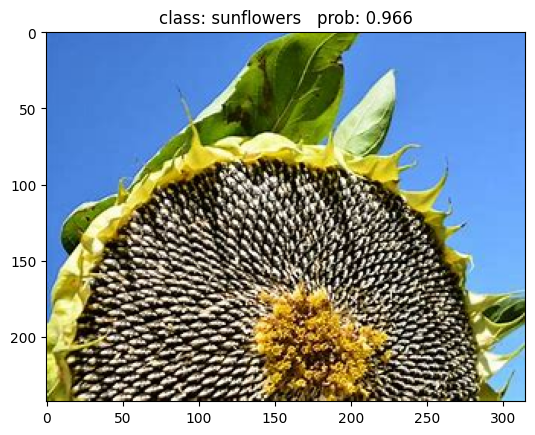

In [6]:
# 数据预处理模型
data_transform = transforms.Compose(
    [transforms.Resize(256),
     transforms.CenterCrop(224),
     transforms.ToTensor(),
     transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

# load image
img_path = "D:\\dataset\\predict\\OIP.jpg" # 换成自己储存待预测图片的路径
assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
img = Image.open(img_path)
plt.imshow(img)
# [N, C, H, W]
img = data_transform(img) # 数据预处理
# expand batch dimension
img = torch.unsqueeze(img, dim=0)

# read class_indict
json_path = './class_indices.json'
assert os.path.exists(json_path), "file: '{}' dose not exist.".format(json_path)

with open(json_path, "r") as f:
    class_indict = json.load(f)

'''训练完即预测，所以下面这部分注释掉'''
# # create model
# model = vit_base_patch16_224_in21k(num_classes=5, has_logits=False).to(device)
# # load model weights
# model_weight_path = "./weights/model-9.pth"
# model.load_state_dict(torch.load(model_weight_path, map_location=device))

model.eval()
with torch.no_grad():
    # predict class
    output = torch.squeeze(model(img.to(device))).cpu()
    predict = torch.softmax(output, dim=0)
    predict_cla = torch.argmax(predict).numpy()

print_res = "class: {}   prob: {:.3}".format(class_indict[str(predict_cla)],
                                             predict[predict_cla].numpy())
plt.title(print_res)
for i in range(len(predict)):
    print("class: {:10}   prob: {:.3}".format(class_indict[str(i)],
                                              predict[i].numpy()))
plt.show()

